# Flicker noise model comparisons

In the context of autocorrelation measurement problems, it is commonly assumed that flicker noise is both Gaussian and stationary.

- **Gaussianity** : The statistical properties are fully characterized by two-point statistics.
- **Stationary Stochastic Process** : The Fourier modes are statistically uncorrelated.
In practice, the second assumption is often implemented using a diagonal covariance matrix for the DFT modes (finite discrete Fourier modes). However, this approach can be problematic, as it introduces nonphysical, spurious cyclic correlations.

A more accurate treatment considers flicker noise as a finite realization from an infinite stochastic process. This notebook presents an alternative 1/f noise models:

**Theoretical Time-Time Covariance** : In this model, flicker noise is considered a finite sample from an infinite continuous stochastic process.

In [1]:
import numpy as np

import sys
sys.path.append('../hydra_tod/')

In [2]:
from flicker_model import *
import matplotlib.pyplot as plt
from utils import *

# Set font for proper displayk
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # for macOS
plt.rcParams['axes.unicode_minus'] = False


In [3]:
# Set simulation parameters

dtime = 2  # Time step
dnu = 2e5  # Frequency resolution
ntime = 2860 # Number of time steps
alpha = 2   # PSD power law index
fknee = 0.001 * 2 * np.pi # Knee frequency in angular frequency
times = np.arange(ntime) * dtime

fft_freqs = np.fft.fftfreq(ntime, d=dtime) * 2 * np.pi
df = fft_freqs[1] - fft_freqs[0]
aux_freqs = fft_freqs[:ntime//2]/(2*np.pi) # Non-negative frequencies in Angular frequency unit (Hz)

## **1**. Traditional method: uncorrelated DFT modes

We draw a number of flicker noise realisations using the method of uncorrelated DFT modes.
With these we can estimate the expected time-time correlation and the power spectral density as the ensemble average.

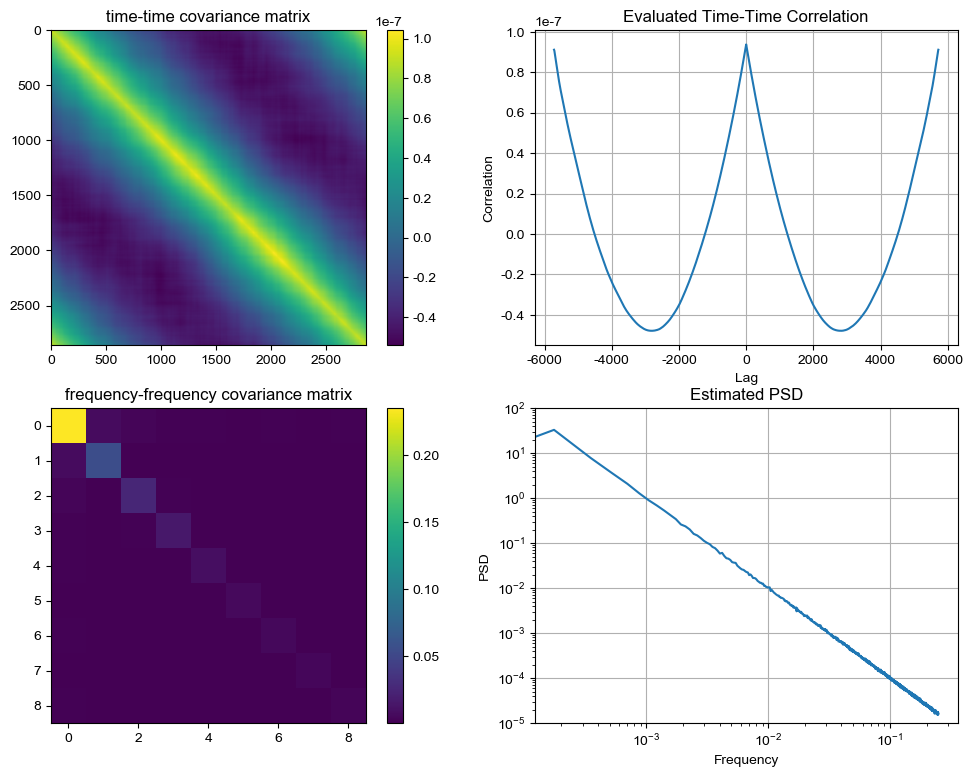

In [13]:
fnoise = FNoise_traditional(alpha=alpha, dtime=dtime, dnu=dnu, fknee=fknee)


nsamples = 1000

cov_matrix_DFT = np.zeros((ntime, ntime))

for i in range(nsamples):
    time_series = fnoise.generate(ntime)
    time_series = time_series 
    cov_matrix_DFT += np.outer(time_series, time_series)

cov_matrix_DFT /= nsamples

# Normalize the covariance matrix using the average of the diagonal elements

corr_simu = np.zeros(2*ntime-1)

for i in range(ntime):
    corr_simu[ntime-1-i] = np.mean(np.diag(cov_matrix_DFT, -i))
    corr_simu[ntime-1+i] = np.mean(np.diag(cov_matrix_DFT, i))


# Plot original signals
plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.imshow(cov_matrix_DFT)
plt.colorbar()
plt.title('time-time covariance matrix')


cov_matrix_fft = cov_conjugate(cov_matrix_DFT, time_to_freq=True)
plt.subplot(223)
plt.imshow(np.abs(cov_matrix_fft)[1:10,1:10])
#plt.xscale('log')
#plt.yscale('log')
plt.title('frequency-frequency covariance matrix')
#set log-scale colorbar
plt.colorbar()


plt.subplot(222)
lags = np.arange(-ntime+1, ntime)*dtime
plt.plot(lags, corr_simu, label='Simulated Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Evaluated Time-Time Correlation')
plt.grid(True)

plt.subplot(224)
PSD_DFT = np.real(np.diag(cov_matrix_fft)[:ntime//2]/(ntime*fnoise.sigma_2))
plt.plot(aux_freqs, PSD_DFT, label='estimated PSD')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.ylim(1e-5, 1e2)
plt.yscale('log')
plt.xscale('log')
plt.title('Estimated PSD')
plt.grid(True)




# **2a**. Flicker noise: Uncorrelated CFT modes 
modeled with theoretical time-time correlation.

In [ ]:
## Which aux_freqs element is the cloest to fknee?
fknee = 1e-3 # Cycle/Time
ind = np.argmin(np.abs(aux_freqs - fknee))
fc = (1/ntime/dtime)*2*np.pi 
logf0_guess = np.log10(  fknee * (ntime*dtime / dnu)**(1/alpha) )

def cost_func(log_f0_val):
    f0_val = 10**log_f0_val
    aux_covmat_CFT = flicker_cov(times, f0_val, fc, alpha, white_n_variance=0)
    aux_covmat_CFT_fft = cov_conjugate(aux_covmat_CFT)
    aux_PSD = np.real( np.diag(aux_covmat_CFT_fft).real[:ntime//2] /(ntime*fnoise.sigma_2) )
    return (aux_PSD[ind]-PSD_DFT[ind])**2

# Minimize the cost function
from scipy.optimize import minimize
res = minimize(cost_func, logf0_guess, method='BFGS')
logf0_opt = res.x[0]
print(logf0_opt)

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/flicker_model.py:118: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  return toeplitz(corr_list)


-4.874571109426952


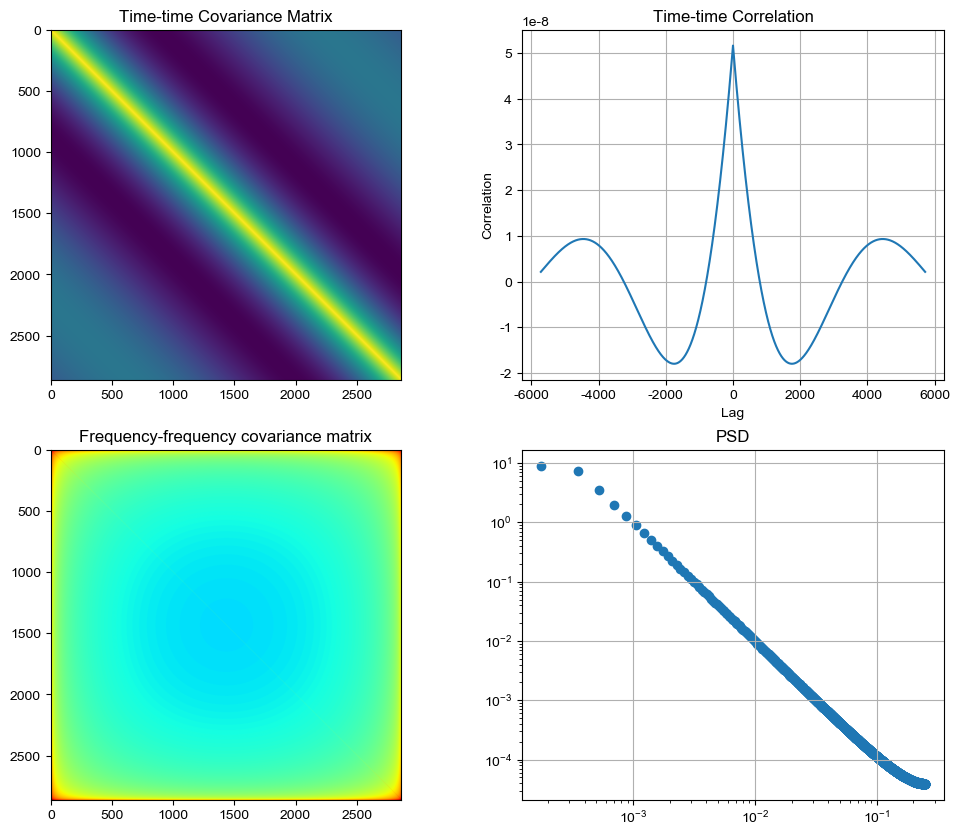

In [ ]:
from matplotlib.colors import LogNorm

f0 = 10**logf0_opt
covmat_CFT = flicker_cov(times, f0, fc, alpha, white_n_variance=0)
covmat_CFT_fft = cov_conjugate(covmat_CFT)

plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.imshow(covmat_CFT) 
plt.colorbar
plt.title('Time-time Covariance Matrix')

corr_simu_2 = np.zeros(2*ntime-1)

for i in range(ntime):
    corr_simu_2[ntime-1-i] = np.mean(np.diag(covmat_CFT, -i))
    corr_simu_2[ntime-1+i] = np.mean(np.diag(covmat_CFT, i))

plt.subplot(222)
plt.plot(lags, corr_simu_2)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Time-time Correlation')
plt.grid()

plt.subplot(223)
plt.imshow(np.abs(covmat_CFT_fft), norm=LogNorm(vmin=1e-10, vmax=1e-3), cmap='jet')
plt.colorbar
plt.title('Frequency-frequency covariance matrix')

PSD_cft = np.diag(covmat_CFT_fft).real[:ntime//2] /(ntime*fnoise.sigma_2)

plt.subplot(224)
aux_freqs = fft_freqs[:ntime//2]/(2*np.pi)
plt.scatter(aux_freqs, PSD_cft)
#plt.plot(aux_freqs[1:], (f0/aux_freqs[1:])**alpha, '--')
#plt.ylim(1e-5, 1e2)
plt.yscale('log')
plt.xscale('log')
plt.title('PSD')
plt.grid()

# * (dtime/ntime/df)


# **2b**. Flicker noise: Uncorrelated CFT modes 
modeled with theoretical time-time correlation.

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/flicker_model.py:118: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  return toeplitz(corr_list)


-3.874259892646189


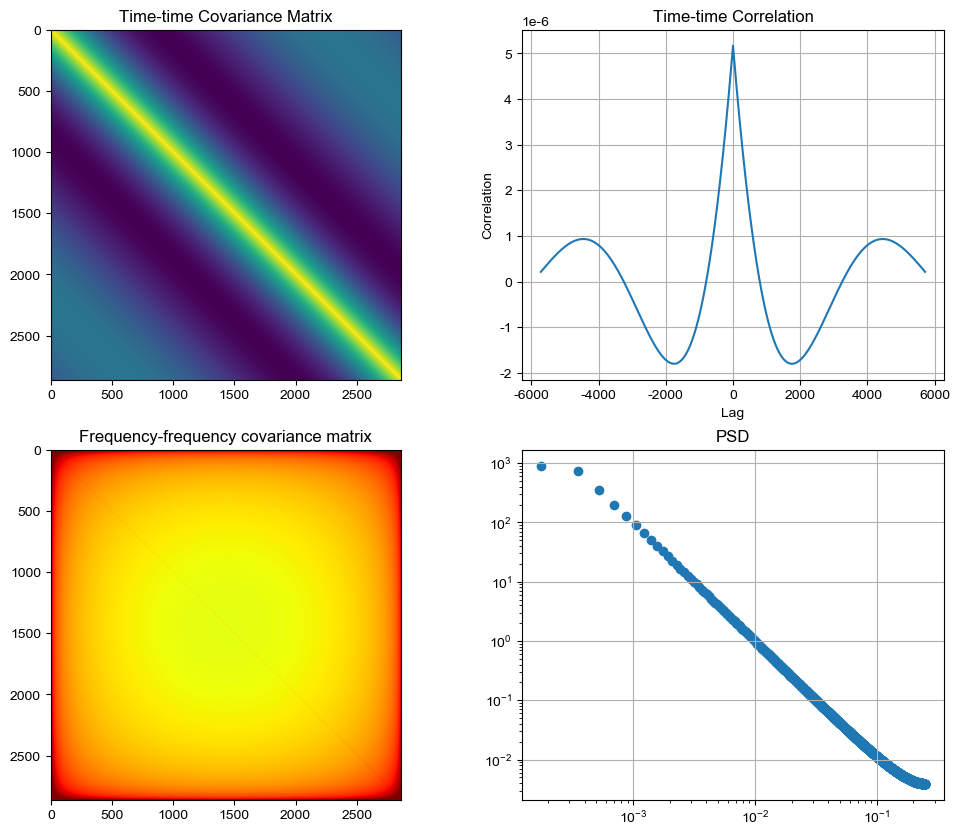

In [44]:
## Which aux_freqs element is the cloest to fknee?
fknee = 1e-2 # Cycle/Time
ind = np.argmin(np.abs(aux_freqs - fknee))
fc = (1/ntime/dtime)*2*np.pi 
logf0_guess = np.log10(  fknee * (ntime*dtime / dnu)**(1/alpha) )

def cost_func(log_f0_val):
    f0_val = 10**log_f0_val
    aux_covmat_CFT = flicker_cov(times, f0_val, fc, alpha, white_n_variance=0)
    aux_covmat_CFT_fft = cov_conjugate(aux_covmat_CFT)
    aux_PSD = np.real( np.diag(aux_covmat_CFT_fft).real[:ntime//2] /(ntime*fnoise.sigma_2) )
    return (aux_PSD[ind]-1)**2

# Minimize the cost function
from scipy.optimize import minimize
res = minimize(cost_func, logf0_guess, method='BFGS')
logf0_opt = res.x[0]
print(logf0_opt)
from matplotlib.colors import LogNorm

f0 = 10**logf0_opt
covmat_CFT = flicker_cov(times, f0, fc, alpha, white_n_variance=0)
covmat_CFT_fft = cov_conjugate(covmat_CFT)

plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.imshow(covmat_CFT) 
plt.colorbar
plt.title('Time-time Covariance Matrix')

corr_simu_2 = np.zeros(2*ntime-1)

for i in range(ntime):
    corr_simu_2[ntime-1-i] = np.mean(np.diag(covmat_CFT, -i))
    corr_simu_2[ntime-1+i] = np.mean(np.diag(covmat_CFT, i))

plt.subplot(222)
plt.plot(lags, corr_simu_2)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Time-time Correlation')
plt.grid()

plt.subplot(223)
plt.imshow(np.abs(covmat_CFT_fft), norm=LogNorm(vmin=1e-10, vmax=1e-3), cmap='jet')
plt.colorbar
plt.title('Frequency-frequency covariance matrix')

PSD_cft = np.diag(covmat_CFT_fft).real[:ntime//2] /(ntime*fnoise.sigma_2)

plt.subplot(224)
aux_freqs = fft_freqs[:ntime//2]/(2*np.pi)
plt.scatter(aux_freqs, PSD_cft)
#plt.plot(aux_freqs[1:], (f0/aux_freqs[1:])**alpha, '--')
#plt.ylim(1e-5, 1e2)
plt.yscale('log')
plt.xscale('log')
plt.title('PSD')
plt.grid()

# * (dtime/ntime/df)


# **2c**. Flicker noise: Uncorrelated CFT modes 
modeled with theoretical time-time correlation.

-2.901434432609383


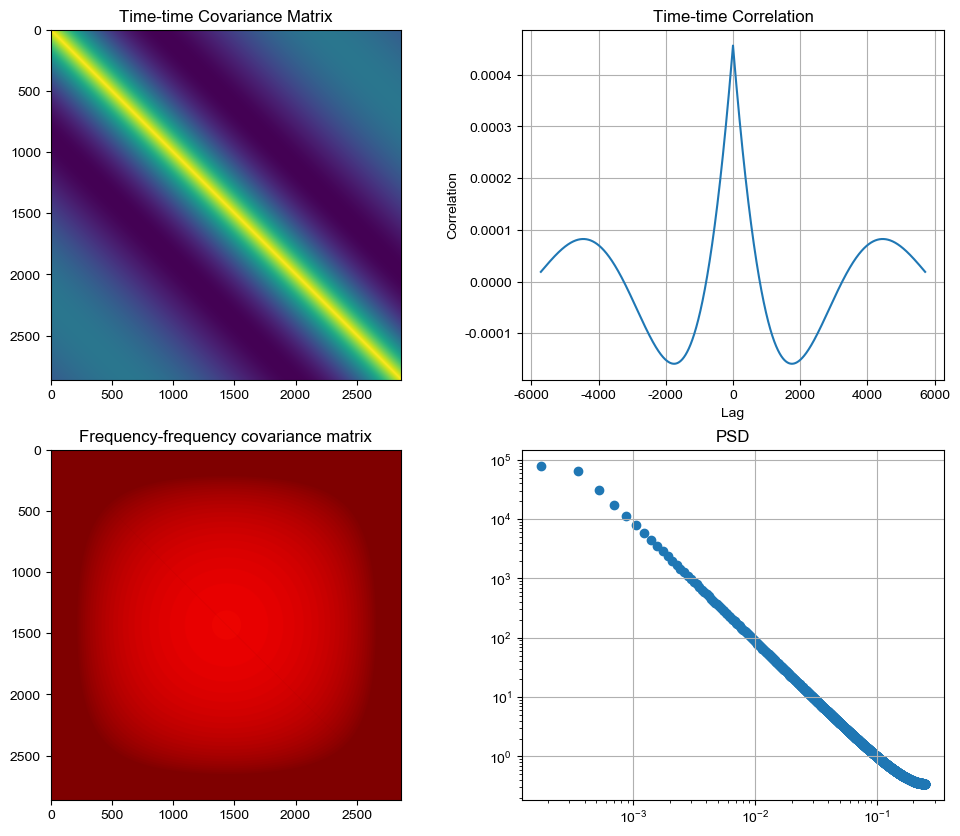

In [45]:
## Which aux_freqs element is the cloest to fknee?
fknee = 1e-1 # Cycle/Time
ind = np.argmin(np.abs(aux_freqs - fknee))
fc = (1/ntime/dtime)*2*np.pi 
logf0_guess = np.log10(  fknee * (ntime*dtime / dnu)**(1/alpha) )

def cost_func(log_f0_val):
    f0_val = 10**log_f0_val
    aux_covmat_CFT = flicker_cov(times, f0_val, fc, alpha, white_n_variance=0)
    aux_covmat_CFT_fft = cov_conjugate(aux_covmat_CFT)
    aux_PSD = np.real( np.diag(aux_covmat_CFT_fft).real[:ntime//2] /(ntime*fnoise.sigma_2) )
    return (aux_PSD[ind]-1)**2

# Minimize the cost function
from scipy.optimize import minimize
res = minimize(cost_func, logf0_guess, method='BFGS')
logf0_opt = res.x[0]
print(logf0_opt)
from matplotlib.colors import LogNorm

f0 = 10**logf0_opt
covmat_CFT = flicker_cov(times, f0, fc, alpha, white_n_variance=0)
covmat_CFT_fft = cov_conjugate(covmat_CFT)

plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.imshow(covmat_CFT) 
plt.colorbar
plt.title('Time-time Covariance Matrix')

corr_simu_2 = np.zeros(2*ntime-1)

for i in range(ntime):
    corr_simu_2[ntime-1-i] = np.mean(np.diag(covmat_CFT, -i))
    corr_simu_2[ntime-1+i] = np.mean(np.diag(covmat_CFT, i))

plt.subplot(222)
plt.plot(lags, corr_simu_2)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Time-time Correlation')
plt.grid()

plt.subplot(223)
plt.imshow(np.abs(covmat_CFT_fft), norm=LogNorm(vmin=1e-10, vmax=1e-3), cmap='jet')
plt.colorbar
plt.title('Frequency-frequency covariance matrix')

PSD_cft = np.diag(covmat_CFT_fft).real[:ntime//2] /(ntime*fnoise.sigma_2)

plt.subplot(224)
aux_freqs = fft_freqs[:ntime//2]/(2*np.pi)
plt.scatter(aux_freqs, PSD_cft)
#plt.plot(aux_freqs[1:], (f0/aux_freqs[1:])**alpha, '--')
#plt.ylim(1e-5, 1e2)
plt.yscale('log')
plt.xscale('log')
plt.title('PSD')
plt.grid()

# * (dtime/ntime/df)


# Plotting

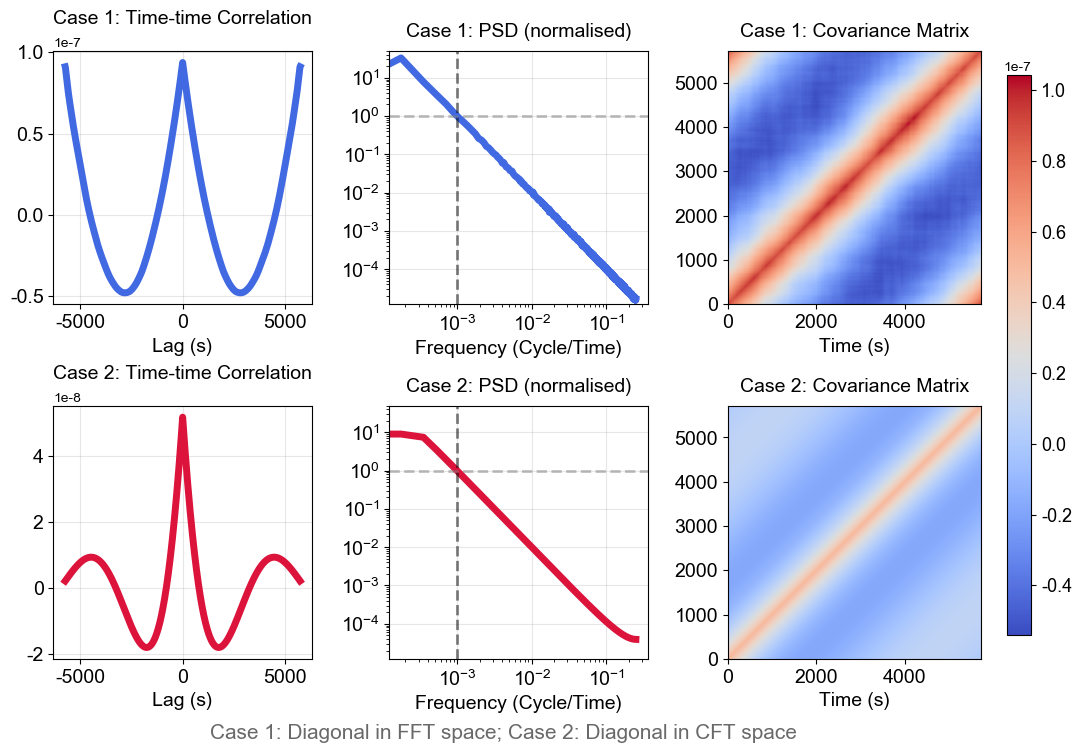

In [41]:
import matplotlib.pyplot as plt

# Create figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Find common vmin/vmax for the covariance matrices
vmin = min(cov_matrix_DFT.min(), covmat_CFT.min())
vmax = max(cov_matrix_DFT.max(), covmat_CFT.max())

ft_size = 16
pd_size = ft_size-6

x_min=times[0]
y_min=times[0]
x_max=times[-1]
y_max=times[-1]
extent = [x_min, x_max, y_min, y_max]

# Case 1 plots
im1 = axs[0, 2].imshow(cov_matrix_DFT, vmin=vmin, vmax=vmax, cmap='coolwarm', extent=extent, origin='lower')
axs[0, 2].set_title('Case 1: Covariance Matrix', fontsize=ft_size, pad=pd_size)
axs[0, 0].plot(lags, corr_simu, color='royalblue', linewidth=5)
axs[0, 0].set_xlabel('Lag (s)', fontsize=ft_size-2)
axs[0, 0].set_title('Case 1: Time-time Correlation', fontsize=ft_size, pad=pd_size)
axs[0, 0].grid(True, alpha=0.3)
axs[0,1].loglog(aux_freqs, PSD_DFT, color='royalblue', linewidth=5)
# Plot a vertical line at x=1e-3
axs[0,1].axvline(x=1e-3, color='black', linestyle='--', linewidth=2, alpha=0.5)
# Plot a horozontal line at y=1
axs[0,1].axhline(y=1, color='gray', linestyle='--', linewidth=2, alpha=0.5)
axs[0,1].set_ylim(1.2e-5, 5e1)
axs[0,1].grid(True, alpha=0.3)
axs[0,1].set_xlabel('Frequency (Cycle/Time)', fontsize=ft_size-2)
axs[0,1].set_title('Case 1: PSD (normalised)', fontsize=ft_size, pad=pd_size)

# Case 2 plots
im2 = axs[1, 2].imshow(covmat_CFT, vmin=vmin, vmax=vmax, cmap='coolwarm', extent=extent, origin='lower')
axs[1, 2].set_title('Case 2: Covariance Matrix', fontsize=ft_size, pad=pd_size)
axs[1, 0].plot(lags, corr_simu_2, color='crimson', linewidth=5)
axs[1, 0].set_xlabel('Lag (s)', fontsize=ft_size-2)
axs[1, 0].set_title('Case 2: Time-time Correlation', fontsize=ft_size, pad=pd_size)
axs[1, 0].grid(True, alpha=0.3)
axs[1,1].loglog(aux_freqs, PSD_cft, color='crimson', linewidth=5)
# Plot a vertical line at x=1e-3
axs[1,1].axvline(x=1e-3, color='black', linestyle='--', linewidth=2, alpha=0.5)
# Plot a horozontal line at y=1
axs[1,1].axhline(y=1, color='gray', linestyle='--', linewidth=2, alpha=0.5)
axs[1,1].set_ylim(1.2e-5, 5e1)
axs[1,1].grid(True, alpha=0.3)
axs[1,1].set_xlabel('Frequency (Cycle/Time)', fontsize=ft_size-2)
axs[1,1].set_title('Case 2: PSD (normalised)', fontsize=ft_size, pad=pd_size)

axs[0, 2].set_xlabel('Time (s)', fontsize=ft_size-2)
axs[1, 2].set_xlabel('Time (s)', fontsize=ft_size-2)

# Adjust font sizes and tick sizes
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=ft_size-2)
    ax.tick_params(axis='both', which='minor', labelsize=ft_size-3)
    ax.set_title(ax.get_title(), fontsize=ft_size-2, pad=pd_size)

# Add common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# Update colorbar with font size
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.ax.tick_params(labelsize=ft_size-3)  # Set tick label size

# Add footnote
plt.figtext(0.5, 0.02, "Case 1: Diagonal in FFT space; Case 2: Diagonal in CFT space", ha="center", fontsize=ft_size-1, color='dimgray')

# Adjust layout and display
plt.subplots_adjust(right=0.9, wspace=0.3, hspace=0.4, bottom=0.12)
plt.savefig('./covariance_camparison.pdf')
plt.show()

In [43]:
fc

0.001098458969786641

## **2b.** A little detour: Decentered flicker noise 

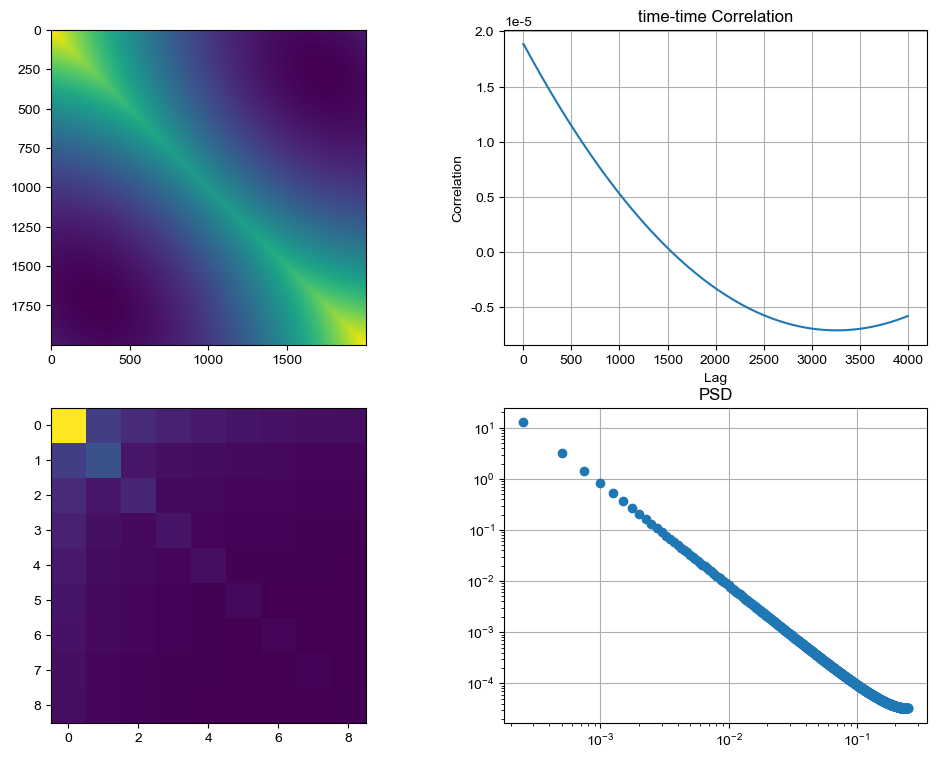

In [21]:
corr_list = [flicker_corr(t, f0, fc, alpha, var_w=0) for t in times]
covmat = toeplitz(corr_list)

covmat_decentered = np.zeros_like(covmat)

covmat_mean = np.mean(covmat)
covmat_row_means = np.mean(covmat, axis=1)

for i in range(len(covmat)):
    for j in range(len(covmat)):
        covmat_decentered[i, j] = covmat[i, j] + covmat_mean - covmat_row_means[i] - covmat_row_means[j]

covmat_decentered_fft = cov_conjugate(covmat_decentered)

plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.imshow(covmat_decentered) 

plt.subplot(222)
plt.plot(times, covmat_decentered[1,:])
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('time-time Correlation')
plt.grid()

plt.subplot(223)
plt.imshow(np.abs(covmat_decentered_fft)[1:10,1:10] )

plt.subplot(224)
plt.plot(fft_freqs[1:ntime//2], np.diag(covmat_decentered_fft).real[1:ntime//2] , 'o')
plt.yscale('log')
plt.xscale('log')
plt.title('PSD')
plt.grid()


## **2c.** Simulate multivariate Gaussian noise (1/f + white) using the time-time covariance matrix

### To check it is consistent with the time-time correlation..

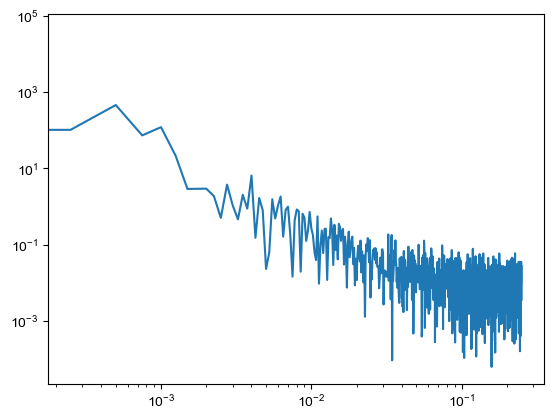

In [11]:
fc = 0.00002
f0 = 0.001
alpha = 2

test = sim_noise(f0, fc, alpha, times, n_samples=1, white_n_variance=5e-6)[0]
psd = np.abs(np.fft.rfft(test))**2
freqs = np.fft.rfftfreq(len(test), d=2)
# plot psd
plt.loglog(freqs, psd)



In [12]:
#fc = 0.00002*2*np.pi
#f0 = 0.000001*2*np.pi
#alpha = 3

corr_list = [flicker_corr(t, f0, fc, alpha, var_w=5e-6) for t in times]
covmat = toeplitz(corr_list)

n_samples = 500

flicker_noise = np.random.multivariate_normal(np.zeros(ntime), covmat, n_samples)

sample_cov = np.zeros((ntime, ntime))



for i in range(n_samples):
    f_n = flicker_noise[i]
    sample_cov += np.outer(f_n, f_n)

sample_cov /= n_samples


/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Theoretical Covariance')

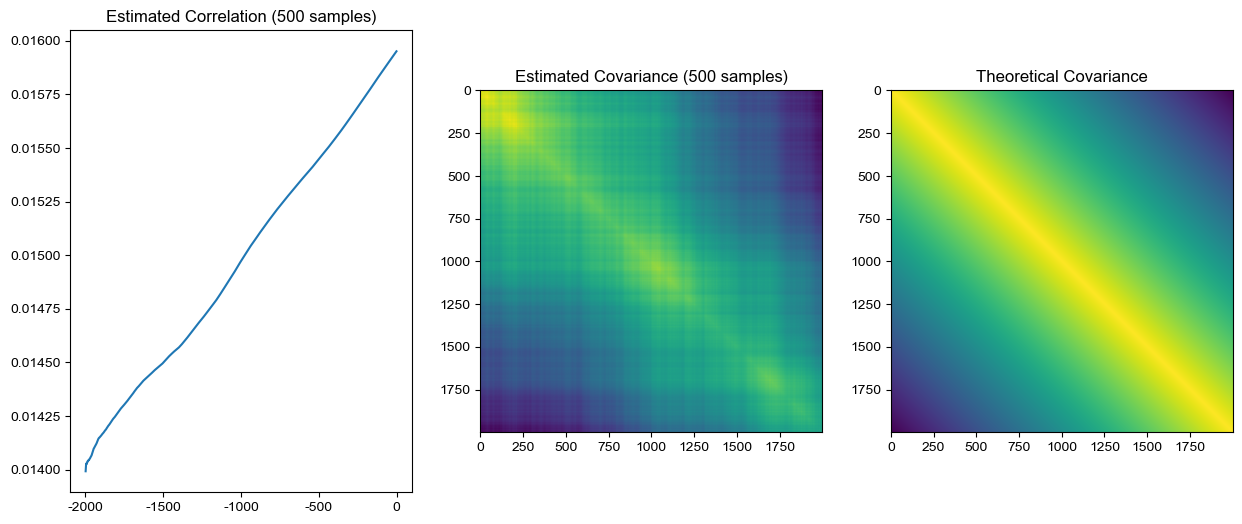

In [13]:

# Estimate the correlation function as mean of each diagonal
sample_corr = np.zeros(2*ntime-1)

for i in range(2*ntime-1):
    sample_corr[i] = np.mean(sample_cov.diagonal(i-ntime))

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
lags = np.arange(1-ntime, ntime)
plt.plot(lags[:ntime-1], sample_corr[:ntime-1])
plt.title("Estimated Correlation (500 samples)")

plt.subplot(1, 3, 2)
plt.imshow(sample_cov)
plt.title("Estimated Covariance (500 samples)")

plt.subplot(1, 3, 3)
plt.imshow(covmat)
plt.title("Theoretical Covariance")

In [14]:
# Create a grid of parameter values

# Compute the likelihood for each parameter combination
# Reshape the likelihood array to match the grid shape
# Plot the likelihood surface
# Create a grid of parameter values

'''
f0_values = 10**(np.linspace(-10, 0, 10))
fc_values = 10**(np.linspace(-10, 0, 10))
alpha_values = np.linspace(1.1, 5, 10)

# Compute the likelihood for each parameter combination
likelihood_values = np.zeros((len(f0_values), len(fc_values), len(alpha_values)))

for i, f0 in enumerate(f0_values):
    for j, fc in enumerate(fc_values):
        for k, alpha in enumerate(alpha_values):
            likelihood_values[i, j, k] = flicker_likelihood_2([f0*2*np.pi, fc*2*np.pi, alpha], times, flicker_noise[0], 0)

# find where the min is:
min_index = np.unravel_index(np.argmin(likelihood_values), likelihood_values.shape)
print("f0: ", f0_values[min_index[0]])
print("fc: ", fc_values[min_index[1]])
print("alpha: ", alpha_values[min_index[2]])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


# Set x, y coordinates for the first subplot
axes[0].imshow(likelihood_values[5, :, :], cmap='viridis', extent=[fc_values.min(), fc_values.max(), alpha_values.min(), alpha_values.max()])
axes[0].set_xlabel('fc_values')
axes[0].set_ylabel('alpha_values')

axes[1].imshow(likelihood_values[:, 5, :], cmap='viridis', extent=[f0_values.min(), f0_values.max(), alpha_values.min(), alpha_values.max()])
axes[1].set_xlabel('f0_values')
axes[1].set_ylabel('alpha_values')

axes[2].imshow(likelihood_values[:, :, 5], cmap='viridis', extent=[f0_values.min(), f0_values.max(), fc_values.min(), fc_values.max()])
axes[2].set_xlabel('f0_values')
axes[2].set_ylabel('fc_values')

plt.show()

'''


'\nf0_values = 10**(np.linspace(-10, 0, 10))\nfc_values = 10**(np.linspace(-10, 0, 10))\nalpha_values = np.linspace(1.1, 5, 10)\n\n# Compute the likelihood for each parameter combination\nlikelihood_values = np.zeros((len(f0_values), len(fc_values), len(alpha_values)))\n\nfor i, f0 in enumerate(f0_values):\n    for j, fc in enumerate(fc_values):\n        for k, alpha in enumerate(alpha_values):\n            likelihood_values[i, j, k] = flicker_likelihood_2([f0*2*np.pi, fc*2*np.pi, alpha], times, flicker_noise[0], 0)\n\n# find where the min is:\nmin_index = np.unravel_index(np.argmin(likelihood_values), likelihood_values.shape)\nprint("f0: ", f0_values[min_index[0]])\nprint("fc: ", fc_values[min_index[1]])\nprint("alpha: ", alpha_values[min_index[2]])\n\nfig, axes = plt.subplots(1, 3, figsize=(15, 5))\n\n\n# Set x, y coordinates for the first subplot\naxes[0].imshow(likelihood_values[5, :, :], cmap=\'viridis\', extent=[fc_values.min(), fc_values.max(), alpha_values.min(), alpha_values.m

### Variance of finite subset

In [15]:
'''
longer_times = np.arange(8*ntime)*dtime
longer_corr_list = [flicker_corr(t, f0*2*np.pi, fc*2*np.pi, alpha, var_w=0) for t in longer_times]
#corr_list = flicker_corr_vectorized(times, f0*2*np.pi, fc*2*np.pi, alpha, var_w=0) 
longer_covmat = toeplitz(longer_corr_list)

long_flicker = np.random.multivariate_normal(np.zeros(8*ntime), longer_covmat, 1)[0]
'''
# PSD of the first 1/8 and last 1/8 of the long flicker noise:


'\nlonger_times = np.arange(8*ntime)*dtime\nlonger_corr_list = [flicker_corr(t, f0*2*np.pi, fc*2*np.pi, alpha, var_w=0) for t in longer_times]\n#corr_list = flicker_corr_vectorized(times, f0*2*np.pi, fc*2*np.pi, alpha, var_w=0) \nlonger_covmat = toeplitz(longer_corr_list)\n\nlong_flicker = np.random.multivariate_normal(np.zeros(8*ntime), longer_covmat, 1)[0]\n'

In [16]:
'''
freq = np.fft.rfftfreq(ntime, d=dtime)

freq_long = np.fft.rfftfreq(8*ntime, d=dtime)

psd1 = 2*np.abs(np.fft.rfft(long_flicker[:ntime]))**2/ntime
psd2 = 2*np.abs(np.fft.rfft(long_flicker[ntime:2*ntime]))**2/ntime
psd4 = 2*np.abs(np.fft.rfft(long_flicker[3*ntime:4*ntime]))**2/ntime
psd8 = 2*np.abs(np.fft.rfft(long_flicker[7*ntime:]))**2/ntime

psd_full = 2*np.abs(np.fft.rfft(long_flicker))**2/(8*ntime)

plt.figure(figsize=(12, 6))
plt.plot(freq, psd1, label='First 1/8')
plt.plot(freq, psd2, label='Second 1/8')
plt.plot(freq, psd4, label='Fourth 1/8')
plt.plot(freq, psd8, label='Last 1/8')
plt.plot(freq_long, psd_full, label='Full')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.xlim(freq.min(), freq.max())
plt.yscale('log')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()
'''

"\nfreq = np.fft.rfftfreq(ntime, d=dtime)\n\nfreq_long = np.fft.rfftfreq(8*ntime, d=dtime)\n\npsd1 = 2*np.abs(np.fft.rfft(long_flicker[:ntime]))**2/ntime\npsd2 = 2*np.abs(np.fft.rfft(long_flicker[ntime:2*ntime]))**2/ntime\npsd4 = 2*np.abs(np.fft.rfft(long_flicker[3*ntime:4*ntime]))**2/ntime\npsd8 = 2*np.abs(np.fft.rfft(long_flicker[7*ntime:]))**2/ntime\n\npsd_full = 2*np.abs(np.fft.rfft(long_flicker))**2/(8*ntime)\n\nplt.figure(figsize=(12, 6))\nplt.plot(freq, psd1, label='First 1/8')\nplt.plot(freq, psd2, label='Second 1/8')\nplt.plot(freq, psd4, label='Fourth 1/8')\nplt.plot(freq, psd8, label='Last 1/8')\nplt.plot(freq_long, psd_full, label='Full')\nplt.xlabel('Frequency (Hz)')\nplt.xscale('log')\nplt.xlim(freq.min(), freq.max())\nplt.yscale('log')\nplt.ylabel('Power Spectral Density')\nplt.legend()\nplt.show()\n"

## **3**. Parameter estimation

In [17]:
from scipy.optimize import minimize


## Fitting for all three parameters..

In [18]:
initial_guess = [-4, -4, 2]
bounds = [(-7, -1), (-7, -1), (1.2, 4.5)]
# Ensure `corr_list` is explicitly cast to float64
time_list = np.asarray(times, dtype=np.float64)

# Ensure `data` is explicitly cast to float64
flicker_noise = np.asarray(flicker_noise, dtype=np.float64)

res = minimize(flicker_likelihood_scaled, initial_guess, args=(time_list, flicker_noise[0], 5e-6), bounds=bounds, tol=1e-15)

log10_f0, log10_fc, estalpha = res.x
estf0 = 10**log10_f0/(2*np.pi)
estfc = 10**log10_fc/(2*np.pi)

print("estimated:", estf0, estfc, estalpha)

print("true:", f0, fc, alpha)

NameError: name 'flicker_likelihood_scaled' is not defined

## Fitting for $f_0$ and $\alpha$, fixing $f_c$.

In [ ]:
def flicker_likelihood_scaled_fix_fc(scaled_params, fc, time_list, data, wnoise_var=5e-6):
    log10_f0, alpha = scaled_params
    f0 = 10**log10_f0 
    return flicker_likelihood_v2([f0, fc, alpha], time_list, data, wnoise_var)

initial_guess = [-4, 2]
bounds = [(-7, -1), (1.2, 4.5)]
# Ensure `corr_list` is explicitly cast to float64
time_list = np.asarray(times, dtype=np.float64)

# Ensure `data` is explicitly cast to float64
flicker_noise = np.asarray(flicker_noise, dtype=np.float64)

res = minimize(flicker_likelihood_scaled_fix_fc, initial_guess, args=(fc*2*np.pi, time_list, flicker_noise[0], 5e-6), bounds=bounds, tol=1e-15)

log10_f0, estalpha = res.x
estf0 = 10**log10_f0/(2*np.pi)

print("estimated:", estf0, estalpha)

print("true:", f0, alpha)

In [ ]:
'''
import emcee

# Define the log-probability function
def log_probability(params, time_list, data):
    log10_f0, log10_fc, alpha = params
    # Check parameter bounds
    if not (-7 < log10_f0 < -1 and -7 < log10_fc < -4 and 1.2 < alpha < 5.5):
        return -np.inf  # Return negative infinity if parameters are out of bounds
    
    
    # Calculate likelihood
    likelihood = flicker_likelihood_scaled(params, time_list, data, 5e-6)
    
    # Check for NaN in likelihood
    if np.isnan(likelihood):
        # Debugging: Print parameter values
        print(f"Parameters: log10_f0={log10_f0}, log10_fc={log10_fc}, alpha={alpha}")
        print("Warning: Likelihood returned NaN")
        return -np.inf
    
    return -likelihood


# Set up the MCMC sampler
nwalkers = 32  # Number of walkers
ndim = 3  # Number of parameters
p0 = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)  # Initial positions of the walkers

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_list, flicker_noise[0]))

# Run the MCMC chain
nsteps = 800  # Number of steps
sampler.run_mcmc(p0, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Estimate the parameters
log10_f0_mcmc, log10_fc_mcmc, alpha_mcmc = np.median(samples, axis=0)
estf0_mcmc, estfc_mcmc = 10**log10_f0_mcmc/(2*np.pi), 10**log10_fc_mcmc/(2*np.pi)

print("MCMC estimated:", estf0_mcmc, estfc_mcmc, alpha_mcmc)
'''